OCR com tesseract

Fontes:

https://nanonets.com/blog/ocr-with-tesseract/

https://realpython.com/python-opencv-color-spaces/

https://docs.opencv.org/4.5.1/d2/de8/group__core__array.html#ga48af0ab51e36436c5d04340e036ce981

Commands: 

#Creating conda enviroment

conda create --name grain-cv python=3.7

#Installing tesseract 

https://digi.bib.uni-mannheim.de/tesseract/tesseract-ocr-w64-setup-v5.0.0.20190623.exe

#Installing packages 

pip install opencv-python-headless Pillow jupyter matplotlib pytesseract --trusted-host pypi.python.org --trusted-host files.pythonhosted.org --trusted-host pypi.org

#Generating requirements 

pip freeze > requirements.txt

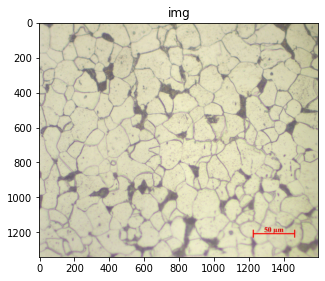

In [360]:
# Imports
import cv2 
import os,argparse 
from PIL import Image 
import matplotlib.pyplot as plt
import re
from segmentation import *

pytesseract.pytesseract.tesseract_cmd = r'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'
import pytesseract
from pytesseract import Output

def rgb2hsv(colors):
    if not isinstance(colors[0], list):
        colors = [colors]
    colors = np.uint8([colors])
    colors = cv2.cvtColor(colors, cv2.COLOR_RGB2HSV)
    return colors[0]

# Tesseract Parameters
custom_config = r'--oem 3 --psm 11'# outputbase digits'
#custom_config = r'-c tessedit_char_whitelist=abcdefghijklmnopqrstuvwxyz --psm 6'
#custom_config = r'-c tessedit_char_blacklist=0123456789 --psm 6'
#custom_config = r'-l eng --psm 6'

# Opening the image
img = cv2.imread("data/Aco224.jpg")
plt.figure(figsize=(5,5)); plt.title("img"); fig = plt.imshow(cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB), 'gray')

In [361]:
mapping = {
    'Aco224.jpg' :            50,
    'Aco417-Analisado.jpg' :   0,
    'Aco417.jpg' :           100,
    'Aco851.jpg' :           100,
    'AcoU.jpg' :             100,
    'AcoW.png' :               0,
    'AcoX.jpg' :               0,
    'AcoZ.png' :             100,
    'Alu205.jpg' :            50,#50
    'Alu50.jpeg' :           200,
    'Alu55.jpg' :             50,
    'Alu69.jpg' :              0,
    'Alu8.jpg' :               0,
    'AluX.jpg' :              50,
    'Ferrite891.png' :         0,
}

In [362]:
# List all files in a directory using os.listdir
def isimageformat(file_str):
    exts = [".png",".jpg",".jpeg",".tif",".tiff",".bmp"]
    for ext in exts:
        if file_str.lower().endswith(ext):
            return ext[1:]
    return False

def tesseract_number(s):
    s = ''.join(c for c in s if c.isdigit() or c in 'AoOIi-./\\')
    s = s.replace('o','0')
    s = s.replace('O','0')
    s = s.replace('A','1')
    s = s.replace('I','1')
    s = s.replace('i','1')
    #s = ''.join([c1 for c0,c1 in zip('9'+s,s) if not(c0=='0' and c1!='0')])
    try: number = round(float(s))
    except: number = None

    return number

def tesseract_img2numbers(img_in, results=[],numbers=[],confs=[], name="", display=False):
    img_tess = img_in.copy()
    # Tesseract processing
    details = pytesseract.image_to_data(img_tess, output_type=Output.DICT, config=custom_config, lang='eng')
    
    conf_max = 0
    for i in range(len(details['text'])):
        conf = int(details['conf'][i])
        number = tesseract_number(details['text'][i])

        if isinstance(number,int) and conf>0:

            (x, y, w, h) = (details['left'][i], details['top'][i], details['width'][i], details['height'][i])

            if display: 
                if conf > conf_max: conf_max = conf

                img_tess = cv2.rectangle(img_tess, (x, y), (x + w, y + h), (0, 255, 0), 2)
                text = "{}:{};{}".format(i,number,conf)
                
                img_tess = cv2.putText(img_tess,text,(x+2-100, y+2), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),4)
                img_tess = cv2.putText(img_tess,text,(x-100, y), cv2.FONT_HERSHEY_SIMPLEX, 1,(0,0,0),2)
            
            results.append((number,conf,(x, y, w, h)));numbers.append(number); confs.append(conf)

    # display image
    if display and conf_max>0:
        plt.figure(figsize=(10,10)); plt.title("img_tess_"+name); fig = plt.imshow(img_tess, 'gray')

def tesseract_byColors(img_in, color_mins=[(0,0,0)], color_maxs=[(255,255,255)], results=[],numbers=[],confs=[], display=False):
    img_hsv = cv2.cvtColor(img_in.copy(), cv2.COLOR_BGR2HSV)
    
    for c0, c1 in zip(color_mins, color_maxs):
        mask = cv2.inRange(img_hsv, c0, c1)
        img_masked = img_hsv.copy()
        if c0[0]==c0[1]==c0[2]!=0:
            img_masked = ~img_masked
        img_masked = cv2.bitwise_and(img_masked, img_masked, mask=mask)
        img_out = cv2.cvtColor(img_masked, cv2.COLOR_HSV2RGB)

        tesseract_img2numbers(img_out,results,numbers,confs,str(c0),display)

def tesseract_byFilters(img_in, results=[],numbers=[],confs=[], display=False):
    img_gray=cv2.cvtColor(img_in.copy(), cv2.COLOR_RGB2GRAY)

    adapt = cv2.ADAPTIVE_THRESH_GAUSSIAN_C
    binn = cv2.THRESH_BINARY

    # Otsu
    #img_out = cv2.threshold(img_gray.copy(), 0,255,binn | cv2.THRESH_OTSU)[1]
    #tesseract_img2numbers(img_out,results,numbers,confs,"otsu",display)
    # Adaptive
    img_out = cv2.adaptiveThreshold(img_gray.copy(), 255, adapt, binn, 191, 3) 
    tesseract_img2numbers(img_out,results,numbers,confs,"adapt",display)
    # Median Blur
    img_out = cv2.medianBlur(img_gray.copy(), 3)
    tesseract_img2numbers(img_out,results,numbers,confs,"blur",display)
    # Erosion
    img_out = cv2.erode(img_gray.copy(), getCircle(3), iterations=1)
    tesseract_img2numbers(img_out,results,numbers,confs,"erosion",display)
    # Dilation
    img_out = cv2.dilate(img_gray.copy(), getCircle(3), iterations=1)
    tesseract_img2numbers(img_out,results,numbers,confs,"dilation",display)
    # Resizing
    img_out = cv2.resize(img_gray.copy(), None, fx=1.5, fy=1.5, interpolation=cv2.INTER_LINEAR)
    tesseract_img2numbers(img_out,results,numbers,confs,"resize",display)

def tesseract_results(results, img_in, name):
    if len(results)>0:
        results_filtered = [(n,c,bb) for n,c,bb in results if (n % 100 == 0 or n == 10 or n == 50)] #filtering
        
        if len(results_filtered)==0:
            results_filtered = [results[0]]
            print("Results[:1]:", results_filtered)
        else:
            results_filtered = sorted(results_filtered, key=(lambda z : z[1]), reverse=True) #sorting
            print("Results[:5]-byConf:", [(n,c) for n,c,_ in results_filtered[:5]])

            results_filtered = sorted(results_filtered, key=(lambda z : z[0]), reverse=True) #sorting
            #results_filtered = [(n,c+20-i,bb) for i,(n,c,bb) in enumerate(results_filtered)]
            print("Results[:5]-byNumber:", [(n,c) for n,c,_ in results_filtered[:5]])

            #results_filtered = sorted(results_filtered, key=(lambda z : sum(z[2][:2])), reverse=True) #sorting
            #results_filtered = [(n,c+20-i,bb) for i,(n,c,bb) in enumerate(results_filtered)]
            #print("Results[:5]-byLocation:", [(n,c) for n,c,_ in results_filtered[:5]])
        
        # Scale
        scale, conf, (xi, yi, wi, hi) = results_filtered[0]
        print("Scale: ", scale)
        
        # Put Text
        text = str([(n,c) for n,c,_ in results_filtered[:5]])
        cv2.putText(img_in, text,(50+2, 50+2), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),6)
        cv2.putText(img_in, text,(50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1,(0,0,0),4)

        # Rectangle
        cv2.rectangle(img_in, (xi, yi), (xi + wi, yi + hi), (0, 255, 0), 2)
        text = "{};{}".format(scale,conf)
        cv2.putText(img_in, text, (xi+2-100, yi+2), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),4)
        cv2.putText(img_in, text, (xi-100, yi), cv2.FONT_HERSHEY_SIMPLEX, 1,(0,0,0),2)

        
    plt.figure(figsize=(5,5)); plt.title("img_"+name); fig = plt.imshow(cv2.cvtColor(img_in, cv2.COLOR_BGR2RGB), 'gray')

    if results_filtered:
        return results_filtered
    return results

[(0, 70, (1294, 1172, 37, 28)), (7, 37, (213, 34, 68, 42)), (0, 46, (595, 373, 25, 13)), (26, 26, (325, 777, 121, 63)), (0, 40, (1237, 770, 160, 142)), (33, 10, (1561, 968, 39, 24)), (50, 96, (1292, 1170, 40, 31)), (1, 65, (1336, 1299, 17, 38)), (1, 10, (99, 585, 56, 23)), (0, 64, (178, 680, 50, 27)), (0, 49, (204, 956, 11, 14)), (0, 39, (384, 1051, 43, 17)), (5, 13, (820, 286, 97, 93)), (3, 32, (1495, 364, 73, 52)), (1, 28, (1400, 734, 197, 76)), (7, 39, (1033, 1187, 20, 16)), (5, 43, (146, 1236, 32, 93)), (0, 26, (246, 1293, 35, 39)), (4, 48, (1151, 8, 40, 15)), (1, 31, (976, 100, 22, 12)), (7, 15, (8, 123, 23, 18)), (1, 38, (342, 150, 8, 30)), (1, 38, (1151, 138, 57, 31)), (1, 28, (1308, 198, 70, 27)), (1, 29, (1243, 237, 65, 26)), (4, 17, (756, 246, 79, 99)), (2, 15, (864, 352, 136, 130)), (5, 16, (234, 501, 22, 20)), (0, 17, (890, 535, 175, 143)), (1, 46, (104, 685, 152, 199)), (4, 18, (111, 901, 145, 77)), (1, 49, (1538, 968, 32, 27)), (253, 33, (1576, 968, 23, 27)), (1, 11, (319

[(50, 96, (1292, 1170, 40, 31)),
 (50, 95, (1938, 1756, 60, 45)),
 (50, 88, (1292, 1171, 40, 30)),
 (50, 78, (1293, 1172, 38, 28)),
 (0, 70, (1294, 1172, 37, 28)),
 (0, 64, (178, 680, 50, 27)),
 (0, 50, (834, 0, 98, 141)),
 (0, 49, (204, 956, 11, 14)),
 (0, 46, (595, 373, 25, 13)),
 (0, 46, (1400, 694, 92, 77)),
 (0, 46, (588, 1177, 80, 57)),
 (0, 40, (1237, 770, 160, 142)),
 (0, 40, (1267, 148, 139, 34)),
 (0, 39, (384, 1051, 43, 17)),
 (0, 37, (895, 562, 34, 14)),
 (0, 27, (1217, 185, 113, 66)),
 (0, 26, (246, 1293, 35, 39)),
 (0, 20, (1066, 989, 167, 164)),
 (0, 17, (890, 535, 175, 143)),
 (0, 16, (111, 902, 92, 80)),
 (0, 10, (112, 902, 90, 79)),
 (0, 9, (1471, 383, 50, 31)),
 (0, 4, (0, 1247, 143, 95))]

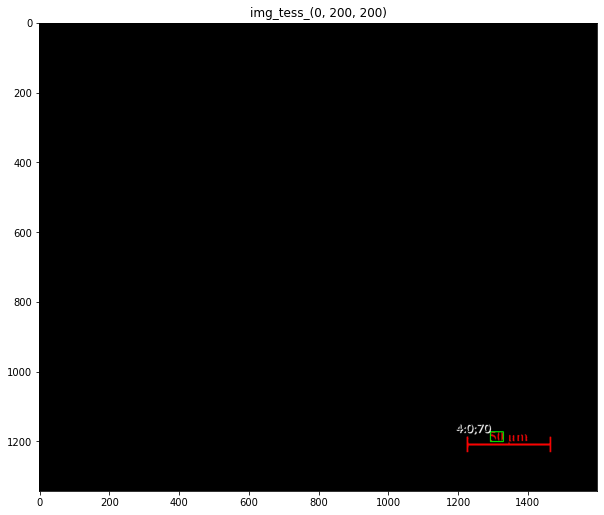

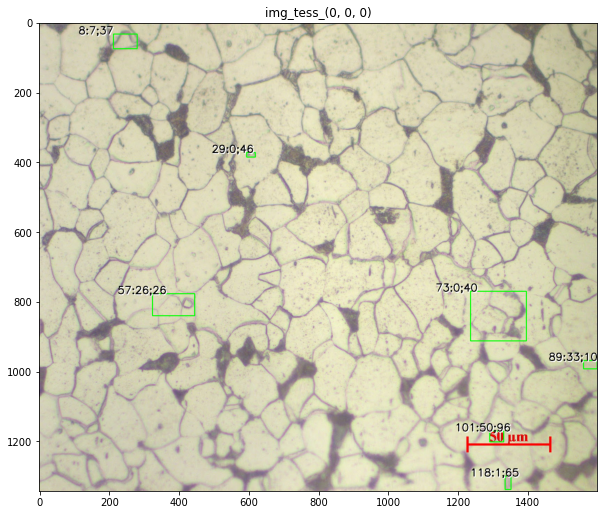

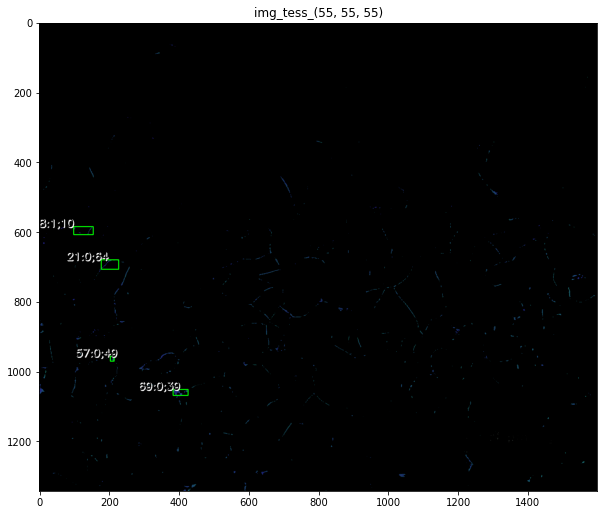

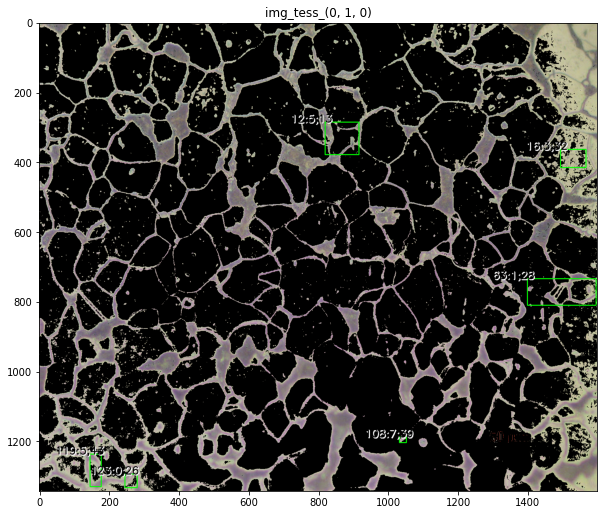

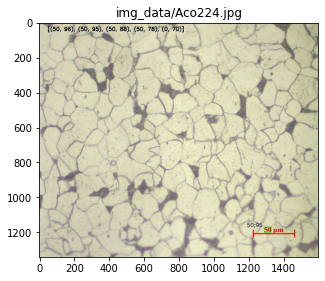

In [363]:
# SINGLE IMAGE

# Tesseract Parameters
#custom_config = r'--oem 3 --psm 11 outputbase digits'
#custom_config = r'--oem 3 --psm 11 outputbase nobatch digits'
custom_config = r'--oem 3 --psm 11'
#custom_config = r'--oem 3 --psm 11 classify_bln_numeric_mode=1 tessedit_char_whitelist=\.0123456789 tessedit_char_blacklist=-,!?@#$%&*()<>_+=/:;\'\"ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
#custom_config = r'-c tessedit_char_whitelist=abcdefghijklmnopqrstuvwxyz --psm 6'
#custom_config = r'-c tessedit_char_blacklist=0123456789 --psm 6'
#custom_config = r'-l eng --psm 6'

# Opening the image
file = "data/Aco224.jpg"
img = cv2.imread(file)

# Reshape
shape_old = img.shape[:2]
if min(shape_old)<500:
    factor = 2
    img = cv2.resize(img, None, fx=factor, fy=factor, interpolation=cv2.INTER_LINEAR)
    print("Reshape:", shape_old, "->", img.shape[:2])
elif min(shape_old)<600:
    factor = 1.5
    img = cv2.resize(img, None, fx=factor, fy=factor, interpolation=cv2.INTER_LINEAR)
    print("Reshape:", shape_old, "->", img.shape[:2])

results = []; numbers = []; confs = []

# Color masking RGB
            #          reds         greens          blues            any          darks         lights
color_mins = [  (0,200,200),   (200,0,200),   (200,200,0),       (0,0,0),    (55,55,55),       (0,1,0)]
color_maxs = [(255,255,255), (255,255,255), (255,255,255), (255,255,255), (255,255,255), (200,200,200)]
tesseract_byColors(img, color_mins, color_maxs, results,numbers,confs, display=True)

# Filters
tesseract_byFilters(img, results, numbers, confs, display=False)

print(results)

tesseract_results(results, img, file)

File: data/Aco224.jpg
Truth: 50
Results[:5]-byConf: [(50, 96), (50, 95), (50, 88), (50, 78), (0, 56)]
Results[:5]-byNumber: [(50, 96), (50, 95), (50, 88), (50, 78), (0, 56)]
Scale:  50

File: data/Aco417.jpg
Truth: 100
Results[:5]-byConf: [(0, 85), (0, 64), (0, 51), (0, 49), (0, 48)]
Results[:5]-byNumber: [(200, 3), (0, 85), (0, 64), (0, 51), (0, 49)]
Scale:  200

File: data/Aco851.jpg
Truth: 100
Results[:5]-byConf: [(100, 76), (100, 73), (10, 69), (0, 58), (0, 57)]
Results[:5]-byNumber: [(100, 76), (100, 73), (100, 24), (100, 23), (100, 19)]
Scale:  100

File: data/AcoU.jpg
Truth: 100
Results[:5]-byConf: [(0, 52), (10, 41), (0, 41), (100, 40), (0, 38)]
Results[:5]-byNumber: [(100, 40), (10, 41), (0, 52), (0, 41), (0, 38)]
Scale:  100

File: data/AcoZ.png
Truth: 100
Reshape: (553, 700) -> (830, 1050)
Results[:5]-byConf: [(0, 83), (0, 60), (0, 60), (0, 54), (0, 54)]
Results[:5]-byNumber: [(100, 48), (0, 83), (0, 60), (0, 60), (0, 54)]
Scale:  100

File: data/Alu205.jpg
Truth: 50
Results

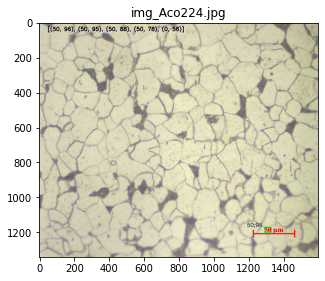

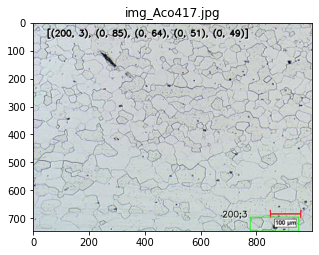

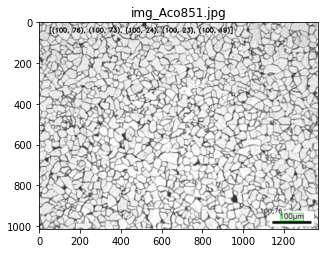

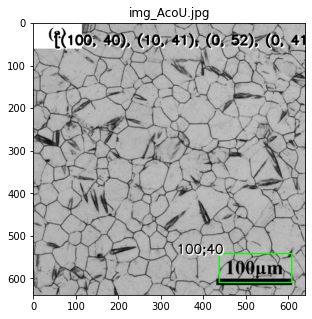

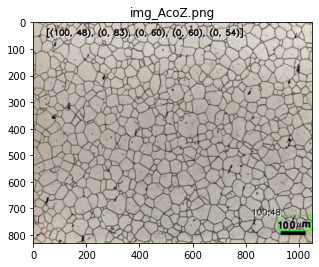

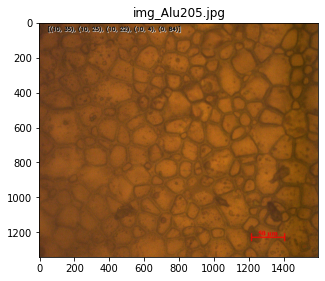

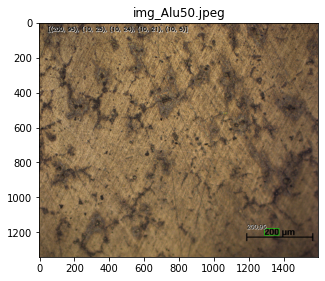

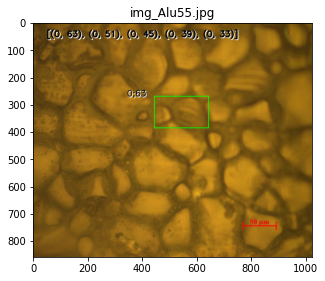

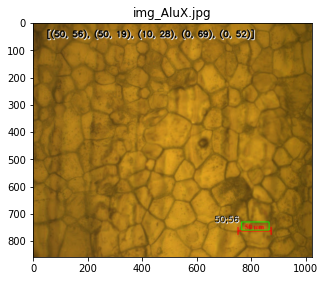

In [364]:
# MULTIPLE IMAGES

def tesseract_byFolder(basepath="./"):
    acc = []
    for file in os.listdir(basepath):
        filepath = os.path.join(basepath, file)
        if os.path.isfile(filepath) and isimageformat(filepath) and mapping[file]>0:
            print("File:", filepath)
            print("Truth:", mapping[file])
            results = []; numbers = []; confs = []

            # Opening the image
            img = cv2.imread(filepath)

            # Reshape
            shape_old = img.shape[:2]
            if min(shape_old)<500:
                factor = 2
                img = cv2.resize(img, None, fx=factor, fy=factor, interpolation=cv2.INTER_LINEAR)
                print("Reshape:", shape_old, "->", img.shape[:2])
            elif min(shape_old)<600:
                factor = 1.5
                img = cv2.resize(img, None, fx=factor, fy=factor, interpolation=cv2.INTER_LINEAR)
                print("Reshape:", shape_old, "->", img.shape[:2])

            # Color masking RGB
                        # reds          greens       blues        any      darks       lights
            color_mins = [(0,150,150), (150,0,150), (150,150,0), (0,0,0), (50,50,50), (1,1,1)]
            color_maxs = [(255,255,255), (255,255,255), (255,255,255), (255,255,255), (50,50,50)]
            tesseract_byColors(img, color_mins, color_maxs, results,numbers,confs, display=False)

            # Filters
            tesseract_byFilters(img, results, numbers, confs, display=False)

            # Results
            results = tesseract_results(results, img, file)

            if results[0][0] == mapping[file]:
                acc.append(1)
            else:
                acc.append(0)
            print()
    print("acc:",acc)
    print("acc-sum:",sum(acc),'/',len(acc))

# Tesseract Parameters
custom_config = r'--oem 3 --psm 11'# outputbase digits'
#custom_config = r'-c tessedit_char_whitelist=abcdefghijklmnopqrstuvwxyz --psm 6'
#custom_config = r'-c tessedit_char_blacklist=0123456789 --psm 6'
#custom_config = r'-l eng --psm 6'

# Applying function
basepath = 'data/'
tesseract_byFolder(basepath)
